In [2]:
from xarray.core.dataarray import DataArray
import metpy.constants as mpconsts
import numpy as np
from metpy import calc as mpcalc
from metpy.interpolate import log_interpolate_1d as log_interp_1d
from metpy.units import units
import os
from pandas.core.series import Series
from xarray.core.dataarray import DataArray


import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import metpy as mp
from metpy.units import units
import metpy.calc as mpc
import Ngl

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_atm(ds):
    ds         = cesm_correct_time(ds)
    dsSel      = ds[['SHFLX','LHFLX','PRECT']]
    # Also select spatial range
    dsSel = dsSel.sel(lat=slice(10,50), lon=slice(190,310))
    return dsSel

def preprocess_atm_profiles(ds):
    ds         = cesm_correct_time(ds)
    dsSel      = ds[['T','Q','PS','hyam','hyai','hybm','hybi','P0']]
    # Also select spatial range
    dsSel = dsSel.sel(lat=slice(10,50), lon=slice(190,310), lev=slice(500,1000))
    return dsSel


def interpolateToPressure(DS, varName, pressGoals):
    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    
    return varInterp

    
# # - - - - - - - - - - - - - - - 
# # Regrid utility 
# # - - - - - - - - - - - - - - - 
# def regrid_data(fromthis, tothis, method=1):
#     """Regrid data using various different methods"""

#     #Import necessary modules:
#     import xarray as xr

#     if method == 1:
#         # kludgy: spatial regridding only, seems like can't automatically deal with time
#         if 'time' in fromthis.coords:
#             result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
#             result = xr.concat(result, 'time')
#             return result
#         else:
#             return fromthis.interp_like(tothis)
#     elif method == 2:
#         newlat = tothis['lat']
#         newlon = tothis['lon']
#         coords = dict(fromthis.coords)
#         coords['lat'] = newlat
#         coords['lon'] = newlon
#         return fromthis.interp(coords)
#     elif method == 3:
#         newlat = tothis['lat']
#         newlon = tothis['lon']
#         ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
#         regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
#         return regridder(fromthis)
#     elif method==4:
#         # geocat
#         newlat = tothis['lat']
#         newlon = tothis['lon']
#         result = geocat.comp.linint2(fromthis, newlon, newlat, False)
#         result.name = fromthis.name
        
#         return result

In [4]:
def calc_ctp(pressure,temperature,start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,interp=False,db=False,plotskewt=False,plotdir="",station=""):

  """ Function for computing the Convective Triggering Potential
  Args:
      pressure (pint.Quantity): the vertical pressure profile
      temperature (pint.Quantity): the vertical temperature profile
      start_pressure_hpa (float, optional): the starting pressure to use. Default: -1 (bottom level in profile).
      bot_pressure_hpa (float, optional): bottom pressure value of the layer, added to start_pressure_hpa. Default: 100 hPa.
      top_pressure_hpa (float, optional): top pressure value of the layer, added to start_pressure_hpa. Default: 300 hPa.
      interp (bool): Whether to interpolate data to exact pressures or use the closest. Default: False.
      db (bool): Print debugging statements. Default: False
      plotskewt (bool): Plot a Skew-T Log-P graphic of the CTP calculation. Default: False.
      plotdir (string, optional): Directory where Skew-T plots should be written. Default: "".
      station (string, optional): Location ID string used for labeling the Skew-T plot and image file name. Default: "".
  Returns:
      float32
 
  Reference:
      TBD
  Notes:
      Lorem Ipsum
  """

  # Set a pressure difference for non-interpolation case
  # If the closest pressure to the bot_pressure_hpa is more
  # than this amount from the start_pressure_hpa, a warning will be
  # printed.
  max_prs_diff = 250.0*units('hPa')

  # # MDF: 11/11/24
  # pressure = pressure * units('hPa')
  # temperature = temperature * units('K')
    
  # Find the starting pressure in the profile
  if start_pressure_hpa < 0:
    start_prs = pressure[0]
    if db:
      print("")
      print("USING LOWEST STARTING PRESSURE: %f\n" % (start_prs.m))
  else:
    if interp:
      start_prs = log_interp_1d(start_pressure_hpa,pressure.m,pressure.m)
      start_prs = start_prs*units('hPa')
      # If the starting pressure is NaN, most likely the starting pressure was lower than
      # all the pressures in the sounding.
      if np.isnan(start_prs):
        if db:
          print("")
          print("WARNING. REQUESTED STARTING PRESSURE INVALID")
          print("UNABLE TO COMPUTE CTP.")
        return(-9999.*units('J/kg'))
      if db:
        print("")
        print("USING INTERPOLATED STARTING PRESSURE: %f\n" % (start_prs.m))
    else:
      # Find the closest value. We'll just take the difference between the start pressure and pressure
      # and find the index of the minimum
      prs_diff = pressure-(start_pressure_hpa*units('hPa'))
      start_prs = pressure[np.argmin(np.abs(prs_diff))]
      if np.abs(start_pressure_hpa-start_prs)>=max_prs_diff:
        print("")
        print("WARNING! ACTUAL STARTING PRESSURE IS AT LEAST %3.2f hPa FROM REQUESTED START PRESSURE." % (max_prs_diff.m))
        print("requested: start_pressure_hpa = %4.2f hPa" % (start_pressure_hpa.m))
        print("actual: start_pressure_hps = %4.2f hPa" % (start_prs.m))
      if db:
        print("")
        print("USING NEAREST STARTING PRESSURE: %f\n" % (start_prs.m))

  # Based on the starting pressure, set the initial layer bottom and top pressures
  layer_bot_prs = start_prs-(bot_pressure_hpa*units('hPa'))
  layer_top_prs = start_prs-(top_pressure_hpa*units('hPa'))

  if db:
    print("")
    print("TARGET LAYER BOTTOM PRESSURE: %f\n" % (layer_bot_prs.m))
    print("TARGET LAYER TOP PRESSURE: %f\n" % (layer_top_prs.m))

  # Obtain information at the top and bottom of the layer
  if interp:
    prsBot, tmpBot = log_interp_1d(layer_bot_prs.m,pressure.m,pressure.m,temperature.m)
    prsTop, tmpTop = log_interp_1d(layer_top_prs.m,pressure.m,pressure.m,temperature.m)
    if db:
      print("")
      print("USING INTERPOLATED LAYER BOTTOM PRESSURE: %f\n" % (prsBot))
      print("USING INTERPOLATED LAYER TOP PRESSURE: %f\n" % (prsTop))

    # Find the top and bottom of the layer, where the interpolated values should be inserted
    if any(np.where(np.diff(pressure.m)<=0)):
      if db:
        print("WARNING! PRESSURES DO NOT MONOTONICALLY DECREASE!")
        print("UNABLE TO COMPUTE CTP.")
      return(-9999.*units('J/kg'))
    layer_bot_idx = len(pressure.m)-np.searchsorted(pressure.m[::-1],prsBot,side="left")[0]
    layer_top_idx = len(pressure.m)-np.searchsorted(pressure.m[::-1],prsTop,side="left")[0]
    if db:
      print("")
      print("INSERTING INTERPOLATED BOT DATA AT INDEX: %02d" % (int(layer_bot_idx)))
      print("INSERTING INTERPOLATED TOP DATA AT INDEX: %02d" % (int(layer_top_idx)))

    # Create a new sounding to use, which has the interpolated T/P at bottom/top inserted
    prs = np.append(np.append(np.append(np.append(pressure.m[0:layer_bot_idx],prsBot),pressure.m[layer_bot_idx:layer_top_idx]),prsTop),pressure.m[layer_top_idx:])
    tmp = np.append(np.append(np.append(np.append(temperature.m[0:layer_bot_idx],tmpBot),temperature.m[layer_bot_idx:layer_top_idx]),tmpTop),temperature.m[layer_top_idx:])
    # Assign units to the new sounding variables
    prs = prs*units('hPa')
    tmp = tmp*units('degK')

    # Reset the variables as if this was the true sounding
    pressure = prs
    temperature = tmp

    # Find the new layer top and bottom indices, which should be the indices of the interpolated values that were inserted above
    layer_bot_idx = np.where(pressure.m==prsBot)[0][0]
    layer_top_idx = np.where(pressure.m==prsTop)[0][0]
    if db:
      print("")
      print("INDEX OF LAYER BOT: %02d" % (int(layer_bot_idx)))
      print("INDEX OF LAYER TOP: %02d" % (int(layer_top_idx)))

    # Compute the moist adiabatic lapse rate
    try:
      MALR = mpcalc.moist_lapse(pressure[layer_bot_idx:],tmpBot*units('degK'),reference_pressure=prsBot*units('hPa'))
    except ValueError:
      print("UNABLE TO COMPUTE MALR IN calc_ctp()")
      return(-9999.*units('J/kg'))

  else:

    # Find the index of the closest value. 
    # We'll just take the difference between the top/bottom pressure and find the index of the minimum
    bot_diff = pressure-layer_bot_prs
    top_diff = pressure-layer_top_prs
    layer_bot_idx = np.argmin(np.abs(bot_diff))
    layer_top_idx = np.argmin(np.abs(top_diff))
    if db:
      print("")
      print("INDEX OF LAYER BOT: %02d" % (int(layer_bot_idx)))
      print("INDEX OF LAYER TOP: %02d" % (int(layer_top_idx)))

    prsBot = pressure.m[layer_bot_idx]
    prsTop = pressure.m[layer_top_idx]
    tmpBot = temperature.m[layer_bot_idx]
    tmpTop = temperature.m[layer_top_idx]

    if db:
      print("")
      print("USING NEAREST LAYER BOTTOM PRESSURE: %f\n" % (prsBot))
      print("USING NEAREST LAYER TOP PRESSURE: %f\n" % (prsTop))

    # Compute the moist adiabatic lapse rate
    try:
      MALR = mpcalc.moist_lapse(pressure[layer_bot_idx:],tmpBot*units('degK'),reference_pressure=prsBot*units('hPa'))
    except ValueError:
      print("UNABLE TO COMPUTE MALR IN calc_ctp()")
      return(-9999.*units('J/kg'))

  # The MALR was only computed from the pressure at the bottom of the layer to the top of the sounding,
  # so subset the data to align with the levels where the MALR was computed
  ctp_prs = pressure[layer_bot_idx:]
  ctp_tmp = temperature[layer_bot_idx:]

  # Compute the difference between the environmental temperature profile and the MALR
  tdiff = (ctp_tmp-MALR)

  # Create a mask for the layer we want to integrate over
  p_mask = (ctp_prs<=pressure[layer_bot_idx])&(ctp_prs>=pressure[layer_top_idx])

  # Compute the Convective Triggering Potential (CTP) index
  CTP = mpconsts.Rd * units.Quantity(np.trapz(tdiff[p_mask].m,np.log(ctp_prs[p_mask].m)),'K')

  if plotskewt:
    import matplotlib.pyplot as plt
    from metpy.plots import SkewT
    fig = plt.figure(1, figsize=(22,15))
    skew = SkewT(fig=fig,rotation=45.0)
    skew.plot(pressure,temperature,'r',marker='.',linewidth=4)
    skew.ax.axhline(y=pressure[layer_bot_idx],xmin=-80,xmax=80,color='k',linewidth=2,linestyle='--')
    skew.ax.axhline(y=pressure[layer_top_idx],xmin=-80,xmax=80,color='k',linewidth=2,linestyle='--')
    skew.ax.fill_betweenx(pressure[layer_bot_idx:layer_top_idx+1],temperature[layer_bot_idx:layer_top_idx+1],MALR[0:(layer_top_idx-layer_bot_idx)+1])
    skew.plot(pressure[layer_bot_idx:],MALR,marker='.',linewidth=4,color='magenta')
    skew.ax.set_ylabel('Pressure (hPa)')
    skew.ax.set_xlabel('Temperature (C)')
    plt.title('CTP = %5.5f J/kg' % (float(CTP.m)),loc='left')
    plt.title('STATION = %s' % (station))
    fig.savefig(os.path.join(plotdir,'CTP_%s.png' % (station)))
    plt.close()

  return CTP.magnitude


### DASK

In [5]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="04:00:00",
    account="P93300042",
    memory="10GB",
    resource_spec="select=1:ncpus=2:mem=10GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
print(client)

cluster.scale(8)

client.wait_for_workers(8)


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37169 instead
  warnings.warn(


<Client: 'tcp://128.117.208.103:42181' processes=0 threads=0, memory=0 B>


## Get data

In [6]:
def preprocess_atm_profiles(ds):
    ds         = cesm_correct_time(ds)
    dsSel      = ds[['T','Q','PS','hyam','hyai','hybm','hybi','P0']]

    # - - - - Isolate only JJA, for years 2 onwards, and only the early morning time each day
    # Drop first year and only keep JJA 
    # iTimes = np.where( (dsSel['time.year'].values>=(dsSel['time.year'].values[0]+1))  & 
    #                    (dsSel['time.month'].values>=6) & (dsSel['time.month'].values<=8) 
    #                   & (dsSel['time.hour'].values==10) )[0]
    iTimes = np.where( (dsSel['time.hour'].values<=13) & (dsSel['time.hour'].values>=10))[0]
    dsSel = dsSel.isel(time=iTimes)
    
    # Also select spatial range (CONUS)
    dsSel = dsSel.sel(lat=slice(10,50), lon=slice(190,310), lev=slice(500,1000))


    return dsSel

In [7]:
caseNames = [
            'f.e21.F2000climo.f09_f09_mg17.S2S_LandAtmCoupling_output.002',
            'f.e21.F2000climo.f09_f09_mg17.ReduceDSL_0p8to0p5.S2S_LandAtmCoupling_output.002',
            # 'i.e21.I2000Clm50Sp.f09_f09_mg17.S2S_LandAtmCoupling_output.002',
            # 'f.e21.FHIST.f09_f09_mg17.S2S_LandAtmCoupling_output.002',
           ]

case_IDs = [
            'F2000climo_ctrl',
            'F2000climo_dsl0p5',
            # 'I2000Clm50Sp',
            # 'FHIST_ctrl', 
            ]

dataDir = '/glade/campaign/cgd/tss/people/mdfowler/LandAtmCoupling_longRuns/'


In [8]:
%%time 

iCase=0

# for iCase in range(len(case_IDs)):
print('*** Starting on case %s ***' % (case_IDs[iCase]))

## Select files with daily means (h1 files in this case)
listFiles_atm_lev = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/*cam.h3.????-*'))


DS_case0 = xr.open_mfdataset(listFiles_atm_lev,  preprocess=preprocess_atm_profiles, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal', parallel=True)

print('atm 3D files loaded')

    

*** Starting on case F2000climo_ctrl ***
atm 3D files loaded
CPU times: user 31.4 s, sys: 2.07 s, total: 33.5 s
Wall time: 3min 1s


In [9]:
## Get landfrac
h0_files = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/*cam.h0.????-*'))
landfrac = xr.open_dataset(h0_files[1]).LANDFRAC
landfrac = landfrac.isel(time=0).sel(lat=slice(10,50), lon=slice(190,310))

In [10]:
landMask = np.ones([len(landfrac.lat.values), len(landfrac.lon.values)])
landMask[np.squeeze(landfrac.values)<=0.45] = np.nan

In [11]:
# Drop first year and only keep JJA 
iTimes = np.where( (DS_case0['time.year'].values>=(DS_case0['time.year'].values[0]+1))  & 
                   (DS_case0['time.month'].values>=6) & (DS_case0['time.month'].values<=8) 
                  )[0]

DS_case0 = DS_case0.isel(time=iTimes)

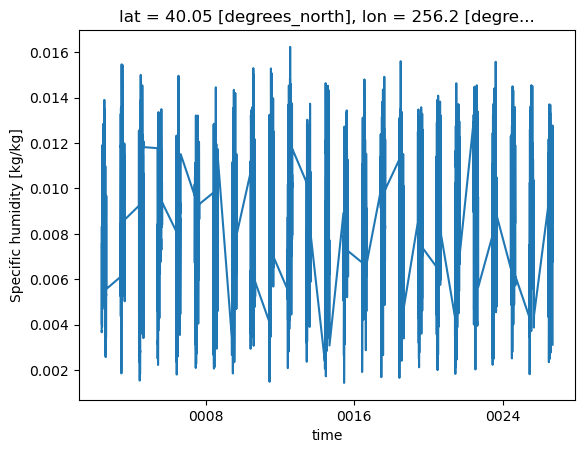

In [12]:
DS_case0.sel(lon=256,lat=40, method='nearest').Q.isel(lev=-2).plot()

In [18]:
selHr = 13

iHours = np.where( (DS_case0['time.hour'].values==13) )[0]
len(iHours)

DS_case0 = DS_case0.isel(time=iHours)

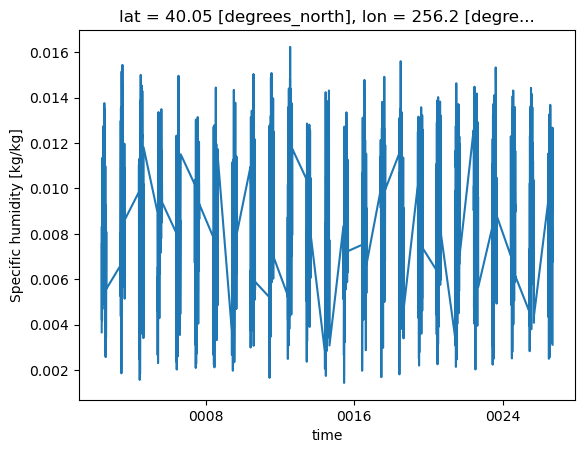

In [14]:
DS_case0.sel(lon=256, lat=40, method='nearest').Q.isel(lev=-2).plot()

In [62]:
#from joblib import Parallel, delayed, parallel_config

In [ ]:
np.arange(900,1000, 25)

In [19]:
P_interp = np.append(np.arange(550, 900, 50), np.arange(900,1000, 25))
# P_interp = np.append(P_interp, 990)

T_interp_temp = interpolateToPressure(DS_case0, 'T', P_interp)

T_interp = xr.DataArray(T_interp_temp, 
    coords={
            'time': DS_case0.time.values,
            'lev':  P_interp,
            'lat':  DS_case0.lat.values, 
            'lon':  DS_case0.lon.values}, 
    dims=["time", "lev", "lat", "lon"])

T_invertLev = T_interp.isel(lev=slice(None, None, -1))


In [20]:
P_interp = np.append(np.arange(550, 900, 50), np.arange(900,1000, 25))
# P_interp = np.append(P_interp, 990)

Q_interp_temp = interpolateToPressure(DS_case0, 'Q', P_interp)

Q_interp = xr.DataArray(Q_interp_temp, 
    coords={
            'time': DS_case0.time.values,
            'lev':  P_interp,
            'lat':  DS_case0.lat.values, 
            'lon':  DS_case0.lon.values}, 
    dims=["time", "lev", "lat", "lon"])

Q_invertLev = Q_interp.isel(lev=slice(None, None, -1))


In [ ]:
DS_case0.time

In [ ]:
print(DS_case0.Q.units)

In [15]:
nTime,nLev,nLat,nLon = np.shape(T_invertLev)

In [16]:
from tqdm import tqdm


In [17]:
# T_invertLev_point = T_invertLev.sel(lon=256, lat=40, method='nearest')
# Q_invertLev_point = Q_invertLev.sel(lon=256, lat=40, method='nearest')

T_invertLev_point = T_invertLev.sel(lon=263, lat=32, method='nearest')
Q_invertLev_point = Q_invertLev.sel(lon=263, lat=32, method='nearest')




In [49]:
T_invertLev_point.time

<xarray.DataArray 'time' (time: 2300)>
array([cftime.DatetimeNoLeap(2, 6, 1, 13, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2, 6, 2, 13, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2, 6, 3, 13, 30, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(26, 8, 29, 13, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(26, 8, 30, 13, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(26, 8, 31, 13, 30, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0002-06-01 13:30:00 ... 0026-08-31 13:30:00
    lat      float64 40.05
    lon      float64 256.2

Text(0, 0.5, 'Bin Count')

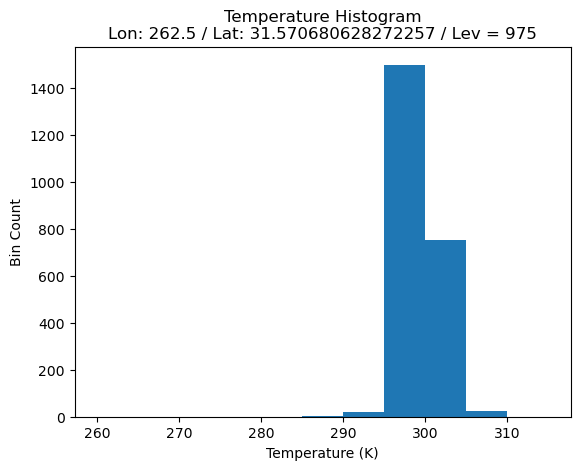

In [18]:
plt.hist(T_invertLev_point.isel(lev=0).values, bins=np.arange(260,320,5))
plt.title('Temperature Histogram\n'+'Lon: '+str(T_invertLev_point.lon.values)+' / Lat: '+str(T_invertLev_point.lat.values) + ' / Lev = '+str(T_invertLev_point.isel(lev=0).lev.values))
plt.xlabel('Temperature (K)')
plt.ylabel('Bin Count')

Text(0, 0.5, 'Bin Count')

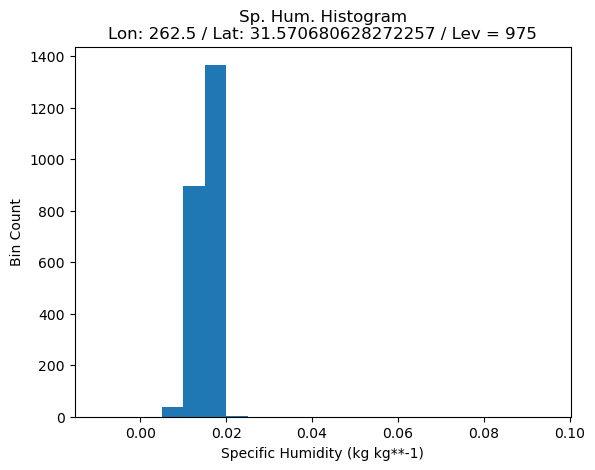

In [19]:
plt.hist(Q_invertLev_point.isel(lev=0).values, bins=np.arange(-0.01,0.1, 0.005))
plt.title('Sp. Hum. Histogram\n'+'Lon: '+str(Q_invertLev_point.lon.values)+' / Lat: '+str(Q_invertLev_point.lat.values) + ' / Lev = '+str(Q_invertLev_point.isel(lev=0).lev.values))
plt.xlabel('Specific Humidity (kg kg**-1)')
plt.ylabel('Bin Count')

In [20]:
dewpoint = mpc.dewpoint_from_specific_humidity(Q_invertLev_point.isel(lev=0).lev.values * units.hPa, 
                                               Q_invertLev_point.isel(lev=0).values * units('kg/kg') )

In [33]:
Q_invertLev_point.isel(lev=1).lev

<xarray.DataArray 'lev' ()>
array(975)
Coordinates:
    lev      int64 975
    lat      float64 38.17
    lon      float64 250.0

In [21]:
dewpoint

Magnitude,[18.894338574630865 17.428931481372047 15.462723994931537 ... 21.658265426146784 21.826634792822517 21.84258270015539]
Units,degree_Celsius


In [28]:
testPoint = np.full([nTime],np.nan)
for iT in range(nTime):
    testPoint[iT] = calc_ctp(T_invertLev_point.lev.values * units.hPa,
                T_invertLev_point.isel(time=iT).values * units.K,
                start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,
                interp=False,db=False,plotskewt=False,plotdir="",station="")
    


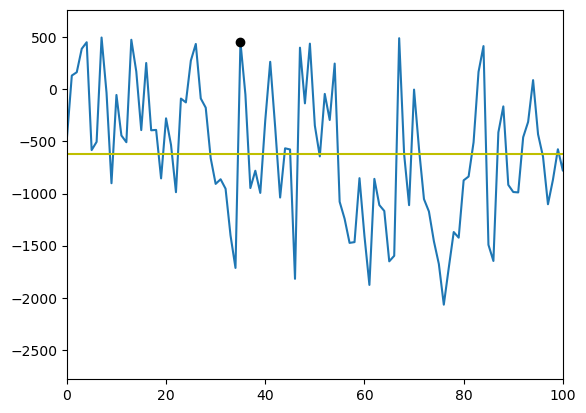

In [29]:
plt.plot(testPoint)
plt.axhline(np.median(testPoint),color='y')
plt.xlim([0,100])
iT = 35
plt.plot(iT,testPoint[iT],'ko')

T_invertLev_point_time = T_invertLev_point.isel(time=iT)

In [181]:
calc_ctp(T_invertLev_point_time.lev.values * units.hPa,
                T_invertLev_point_time.values * units.K,
                start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,
                interp=False,db=True,plotskewt=False,plotdir="",station="")


USING LOWEST STARTING PRESSURE: 990.000000


TARGET LAYER BOTTOM PRESSURE: 890.000000

TARGET LAYER TOP PRESSURE: 690.000000


INDEX OF LAYER BOT: 04
INDEX OF LAYER TOP: 08

USING NEAREST LAYER BOTTOM PRESSURE: 900.000000

USING NEAREST LAYER TOP PRESSURE: 700.000000



451.0608590785801

In [22]:
pressure    = T_invertLev_point_time.sel(lev=slice(900,700)).lev.values * units.hPa
temperature = T_invertLev_point.isel(time=iT).sel(lev=slice(900,700)).values * units.K
moisture    = Q_invertLev_point.isel(time=iT).sel(lev=slice(900,700)).values *1e3 * units('g/kg')

dewpoint_time   = dewpoint.m[iT] * dewpoint.u
temperature_sfc = T_invertLev_point.isel(time=iT, lev=0).values * units.K


NameError: name 'T_invertLev_point_time' is not defined

In [167]:
print(pressure)
print(temperature)
print(moisture * 1e3 * units('g/kg'))

[900 850 800 750 700] hectopascal
[308.93170587285846 303.49615007638056 298.53727246979383 296.2320041201997 290.9509822810801] kelvin
[13.56641121060293 10.242354840748153 6.866398179431457 5.314958056508732 5.402689836589365] gram / kilogram


In [176]:
dewp = np.full([len(pressure.m)], np.nan)
for iLev in range(len(pressure.m)):23wza c
    dewp[iLev] = mpc.dewpoint_from_specific_humidity(pressure.m[iLev] * pressure.u, moisture.m[iLev] * moisture.u ).m

In [177]:
parcProf = mpc.parcel_profile(pressure, 
                              temperature_sfc, dewpoint_time) 

In [179]:

cape,cin = mpc.cape_cin(pressure, temperature, dewp * dewpoint.u, 
                        parcProf, which_lfc='bottom', which_el='top')

print(cape)
print(cin)



0 joule / kilogram
0 joule / kilogram


In [183]:
# def calc_ctp(pressure,temperature,start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,interp=False,db=False,plotskewt=False,plotdir="",station=""):

  """ Function for computing the Convective Triggering Potential
  Args:
      pressure (pint.Quantity): the vertical pressure profile
      temperature (pint.Quantity): the vertical temperature profile
      start_pressure_hpa (float, optional): the starting pressure to use. Default: -1 (bottom level in profile).
      bot_pressure_hpa (float, optional): bottom pressure value of the layer, added to start_pressure_hpa. Default: 100 hPa.
      top_pressure_hpa (float, optional): top pressure value of the layer, added to start_pressure_hpa. Default: 300 hPa.
      interp (bool): Whether to interpolate data to exact pressures or use the closest. Default: False.
      db (bool): Print debugging statements. Default: False
      plotskewt (bool): Plot a Skew-T Log-P graphic of the CTP calculation. Default: False.
      plotdir (string, optional): Directory where Skew-T plots should be written. Default: "".
      station (string, optional): Location ID string used for labeling the Skew-T plot and image file name. Default: "".
  Returns:
      float32
 
  Reference:
      TBD
  Notes:
      Lorem Ipsum
  """

    max_prs_diff = 250.0*units('hPa')

  # # MDF: 11/11/24
  # pressure = pressure * units('hPa')
  # temperature = temperature * units('K')
    
  # Find the starting pressure in the profile
  if start_pressure_hpa < 0:
    start_prs = pressure[0]
    if db:
      print("")
      print("USING LOWEST STARTING PRESSURE: %f\n" % (start_prs.m))
 
  # Based on the starting pressure, set the initial layer bottom and top pressures
  layer_bot_prs = start_prs-(bot_pressure_hpa*units('hPa'))
  layer_top_prs = start_prs-(top_pressure_hpa*units('hPa'))

  if db:
    print("")
    print("TARGET LAYER BOTTOM PRESSURE: %f\n" % (layer_bot_prs.m))
    print("TARGET LAYER TOP PRESSURE: %f\n" % (layer_top_prs.m))

  # Obtain information at the top and bottom of the layer
  if interp:
    prsBot, tmpBot = log_interp_1d(layer_bot_prs.m,pressure.m,pressure.m,temperature.m)
    prsTop, tmpTop = log_interp_1d(layer_top_prs.m,pressure.m,pressure.m,temperature.m)
    if db:
      print("")
      print("USING INTERPOLATED LAYER BOTTOM PRESSURE: %f\n" % (prsBot))
      print("USING INTERPOLATED LAYER TOP PRESSURE: %f\n" % (prsTop))

    # Find the top and bottom of the layer, where the interpolated values should be inserted
    if any(np.where(np.diff(pressure.m)<=0)):
      if db:
        print("WARNING! PRESSURES DO NOT MONOTONICALLY DECREASE!")
        print("UNABLE TO COMPUTE CTP.")
      return(-9999.*units('J/kg'))
    layer_bot_idx = len(pressure.m)-np.searchsorted(pressure.m[::-1],prsBot,side="left")[0]
    layer_top_idx = len(pressure.m)-np.searchsorted(pressure.m[::-1],prsTop,side="left")[0]
    if db:
      print("")
      print("INSERTING INTERPOLATED BOT DATA AT INDEX: %02d" % (int(layer_bot_idx)))
      print("INSERTING INTERPOLATED TOP DATA AT INDEX: %02d" % (int(layer_top_idx)))

    # Create a new sounding to use, which has the interpolated T/P at bottom/top inserted
    prs = np.append(np.append(np.append(np.append(pressure.m[0:layer_bot_idx],prsBot),pressure.m[layer_bot_idx:layer_top_idx]),prsTop),pressure.m[layer_top_idx:])
    tmp = np.append(np.append(np.append(np.append(temperature.m[0:layer_bot_idx],tmpBot),temperature.m[layer_bot_idx:layer_top_idx]),tmpTop),temperature.m[layer_top_idx:])
    # Assign units to the new sounding variables
    prs = prs*units('hPa')
    tmp = tmp*units('degK')

    # Reset the variables as if this was the true sounding
    pressure = prs
    temperature = tmp

    # Find the new layer top and bottom indices, which should be the indices of the interpolated values that were inserted above
    layer_bot_idx = np.where(pressure.m==prsBot)[0][0]
    layer_top_idx = np.where(pressure.m==prsTop)[0][0]
    if db:
      print("")
      print("INDEX OF LAYER BOT: %02d" % (int(layer_bot_idx)))
      print("INDEX OF LAYER TOP: %02d" % (int(layer_top_idx)))

    # Compute the moist adiabatic lapse rate
    try:
      MALR = mpcalc.moist_lapse(pressure[layer_bot_idx:],tmpBot*units('degK'),reference_pressure=prsBot*units('hPa'))
    except ValueError:
      print("UNABLE TO COMPUTE MALR IN calc_ctp()")
      return(-9999.*units('J/kg'))

  else:

    # Find the index of the closest value. 
    # We'll just take the difference between the top/bottom pressure and find the index of the minimum
    bot_diff = pressure-layer_bot_prs
    top_diff = pressure-layer_top_prs
    layer_bot_idx = np.argmin(np.abs(bot_diff))
    layer_top_idx = np.argmin(np.abs(top_diff))
    if db:
      print("")
      print("INDEX OF LAYER BOT: %02d" % (int(layer_bot_idx)))
      print("INDEX OF LAYER TOP: %02d" % (int(layer_top_idx)))

    prsBot = pressure.m[layer_bot_idx]
    prsTop = pressure.m[layer_top_idx]
    tmpBot = temperature.m[layer_bot_idx]
    tmpTop = temperature.m[layer_top_idx]
    if db: 
        print("")
        print("prsBot = ", prsBot)
        print("prsTop = ", prsTop)
        print("tmpBot = ", tmpBot)
        print("tmpTop = ", tmpTop)

    if db:
      print("")
      print("USING NEAREST LAYER BOTTOM PRESSURE: %f\n" % (prsBot))
      print("USING NEAREST LAYER TOP PRESSURE: %f\n" % (prsTop))

    # Compute the moist adiabatic lapse rate
    try:
      MALR = mpcalc.moist_lapse(pressure[layer_bot_idx:],tmpBot*units('degK'),reference_pressure=prsBot*units('hPa'))
    except ValueError:
      print("UNABLE TO COMPUTE MALR IN calc_ctp()")
      return(-9999.*units('J/kg'))

  # The MALR was only computed from the pressure at the bottom of the layer to the top of the sounding,
  # so subset the data to align with the levels where the MALR was computed
  ctp_prs = pressure[layer_bot_idx:]
  ctp_tmp = temperature[layer_bot_idx:]

  # Compute the difference between the environmental temperature profile and the MALR
  tdiff = (ctp_tmp-MALR)

  # Create a mask for the layer we want to integrate over
  p_mask = (ctp_prs<=pressure[layer_bot_idx])&(ctp_prs>=pressure[layer_top_idx])

  # Compute the Convective Triggering Potential (CTP) index
  CTP = mpconsts.Rd * units.Quantity(np.trapz(tdiff[p_mask].m,np.log(ctp_prs[p_mask].m)),'K')


IndentationError: unexpected indent (4080979236.py, line 3)

In [32]:
# output=np.full([nTime,nLat,nLon], np.nan)

# for iLat in tqdm(range(nLat)):
#     for iLon in range(nLon):
#         if np.isfinite(landMask[iLat,iLon]):
#             for iT in range(nTime):
#                 output[iT,iLat,iLon] = calc_ctp(T_invertLev.lev.values * units.hPa,
#                             T_invertLev.isel(time=iT,lat=iLat,lon=iLon).values * units.K,
#                             start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,
#                             interp=False,db=False,plotskewt=False,plotdir="",station="")
                


100%|██████████| 42/42 [2:14:44<00:00, 192.49s/it]


In [33]:
# ctp = xr.DataArray(output, 
#     coords={
#             'time': T_invertLev.time.values,
#             'lat':  T_invertLev.lat.values, 
#             'lon':  T_invertLev.lon.values}, 
#     dims=["time", "lat", "lon"])


In [34]:
# outdir = '/glade/derecho/scratch/mdfowler/S2S_processed/'
# fileName = outdir+caseNames[0]+'_CTP_JJA_13utc.nc'

# ctp.to_netcdf(path=fileName)


In [19]:
DS_case0.lat.values

array([10.83769634, 11.78010471, 12.72251309, 13.66492147, 14.60732984,
       15.54973822, 16.4921466 , 17.43455497, 18.37696335, 19.31937173,
       20.2617801 , 21.20418848, 22.14659686, 23.08900524, 24.03141361,
       24.97382199, 25.91623037, 26.85863874, 27.80104712, 28.7434555 ,
       29.68586387, 30.62827225, 31.57068063, 32.51308901, 33.45549738,
       34.39790576, 35.34031414, 36.28272251, 37.22513089, 38.16753927,
       39.10994764, 40.05235602, 40.9947644 , 41.93717277, 42.87958115,
       43.82198953, 44.76439791, 45.70680628, 46.64921466, 47.59162304,
       48.53403141, 49.47643979])

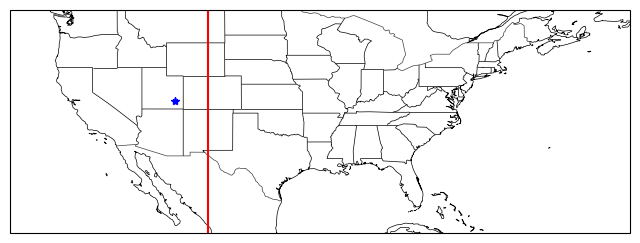

In [31]:
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


fig, axs = plt.subplots(1,1, figsize=(8, 3), 
                        subplot_kw={'projection':ccrs.PlateCarree()})

## Set up the map with boundaries, limited extent, etc.
axs.set_extent([230,305,22,49], crs=ccrs.PlateCarree())

axs.coastlines(linewidth=0.5,edgecolor='0.25')
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5) 

# axs[0].plot(np.ones(29)*249, np.arange(22,51), color='red', transform=ccrs.PlateCarree())
axs.plot(np.ones(29)*254, np.arange(22,51), color='red', transform=ccrs.PlateCarree())

axs.plot(250,38,'b*', transform=ccrs.PlateCarree())


In [21]:
outdir = '/glade/derecho/scratch/mdfowler/S2S_processed/'

ctp_10utc = xr.open_dataset(outdir+caseNames[0]+'_CTP_JJA_10utc.nc')
ctp_13utc = xr.open_dataset(outdir+caseNames[0]+'_CTP_JJA_13utc.nc')


## Around longitude = 110, switch from 13 UTC to 10 UTC. Could also try 105, which is ~longitude of Denver (going with Denver) 
iLon = np.where( (T_invertLev.lon.values>=254) & (T_invertLev.lon.values<=256))[0] 

ctp_combined = ctp_13utc.__xarray_dataarray_variable__.values
ctp_combined[:,:,iLon[0]::] = ctp_10utc.__xarray_dataarray_variable__.values[:,:,iLon[0]::]

ctp = xr.DataArray(ctp_combined, 
    coords={
            'time': T_invertLev.time.values,
            'lat':  T_invertLev.lat.values, 
            'lon':  T_invertLev.lon.values}, 
    dims=["time", "lat", "lon"])


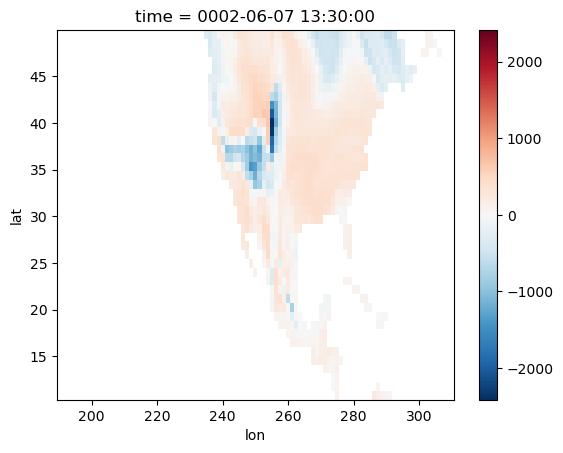

In [56]:
ctp.isel(time=6).plot()

In [22]:
ctp_noZeros = ctp.where(ctp.values>=0)


Text(0.5, 1.0, 'Median of positive CTP days')

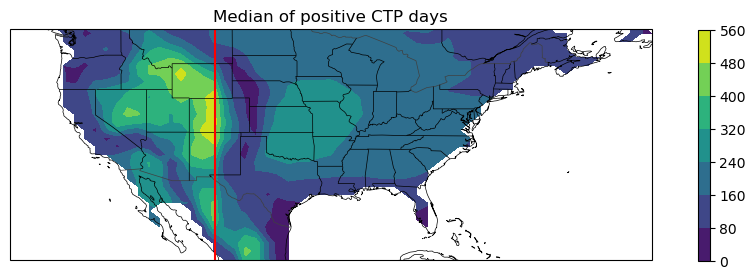

In [201]:
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


fig, axs = plt.subplots(1,1, figsize=(12, 3), 
                        subplot_kw={'projection':ccrs.PlateCarree()})

## Set up the map with boundaries, limited extent, etc.
axs.set_extent([230,305,22,49], crs=ccrs.PlateCarree())

axs.coastlines(linewidth=0.5,edgecolor='0.25')
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5) 

# axs[0].plot(np.ones(29)*249, np.arange(22,51), color='red', transform=ccrs.PlateCarree())
axs.plot(np.ones(29)*254, np.arange(22,51), color='red', transform=ccrs.PlateCarree())

p1 = axs.contourf(ctp_noZeros.lon.values, ctp_noZeros.lat.values, 
            ctp_noZeros.median(dim='time').values,transform=ccrs.PlateCarree() )
fig.colorbar(p1)
axs.set_title('Median of positive CTP days')

Text(0.5, 1.0, 'Median of CTP on *all* days')

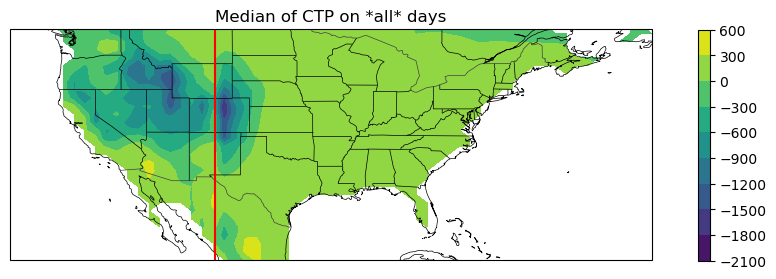

In [202]:
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


fig, axs = plt.subplots(1,1, figsize=(12, 3), 
                        subplot_kw={'projection':ccrs.PlateCarree()})

## Set up the map with boundaries, limited extent, etc.
axs.set_extent([230,305,22,49], crs=ccrs.PlateCarree())

axs.coastlines(linewidth=0.5,edgecolor='0.25')
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5) 

# axs[0].plot(np.ones(29)*249, np.arange(22,51), color='red', transform=ccrs.PlateCarree())
axs.plot(np.ones(29)*254, np.arange(22,51), color='red', transform=ccrs.PlateCarree())

p1 = axs.contourf(ctp.lon.values, ctp.lat.values, 
            ctp.median(dim='time').values,transform=ccrs.PlateCarree() )
fig.colorbar(p1)
axs.set_title('Median of CTP on *all* days')

## Compute HIlow

In [1]:
P_interp = np.append(np.arange(550, 900, 50), np.arange(900,1000, 25))
P_interp = np.append(P_interp, 990)

Q_interp_temp = interpolateToPressure(DS_case0, 'Q', P_interp)

Q_interp = xr.DataArray(Q_interp_temp, 
    coords={
            'time': DS_case0.time.values,
            'lev':  P_interp,
            'lat':  DS_case0.lat.values, 
            'lon':  DS_case0.lon.values}, 
    dims=["time", "lev", "lat", "lon"])

Q_invertLev = Q_interp.isel(lev=slice(None, None, -1))


NameError: name 'np' is not defined

In [23]:
%%time

dewpoint_950 = mpc.dewpoint_from_specific_humidity(Q_invertLev.sel(lev=950, method='nearest').lev.values * units.hPa, 
                                                   Q_invertLev.sel(lev=950, method='nearest').values * units(DS_case0.Q.units))

dewpoint_850 = mpc.dewpoint_from_specific_humidity(Q_invertLev.sel(lev=850, method='nearest').lev.values * units.hPa, 
                                                   Q_invertLev.sel(lev=850, method='nearest').values * units(DS_case0.Q.units))


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


CPU times: user 331 ms, sys: 369 ms, total: 700 ms
Wall time: 773 ms


In [150]:
dewpoint_850.units

<Unit('degree_Celsius')>

In [24]:
# tmpBot =  T_invertLev.sel(lev=950, method='nearest').values * units(DS_case0.T.units) -273.15
# tmpTop =  T_invertLev.sel(lev=850, method='nearest').values * units(DS_case0.T.units) -273.15
tmpBot =  T_invertLev.sel(lev=950, method='nearest').values -273.15
tmpTop =  T_invertLev.sel(lev=850, method='nearest').values -273.15

HIlow = (tmpBot-dewpoint_950.m) + (tmpTop-dewpoint_850.m)

In [189]:
HIlow

array([[[ 9.27935027e+00,  7.22973085e+00,  6.39311782e+00, ...,
          6.24484126e+00,  6.25566101e+00,  6.08338476e+00],
        [ 1.12997425e+01,  1.00371584e+01,  8.85662481e+00, ...,
          9.62375079e+00,  1.04702180e+01,  1.05920684e+01],
        [ 1.16906693e+01,  1.18584006e+01,  1.08199833e+01, ...,
          1.22948134e+01,  1.25521382e+01,  1.24102735e+01],
        ...,
        [ 7.14032066e-01,  9.82176899e-01,  1.46445784e+00, ...,
          1.25391699e+00,  5.65485280e-01,  1.67140136e-02],
        [ 1.90639835e-02,  1.33083033e-01,  1.00574710e+00, ...,
          1.94845401e+00,  1.27159414e+00,  1.00211639e-01],
        [ 3.78426115e-02,  1.72482110e-01,  3.52067568e-01, ...,
          2.10628979e+00,  2.40491620e+00,  1.20720213e+00]],

       [[ 2.72061119e+00,  2.73987221e+00,  3.18965488e+00, ...,
          1.03594036e+01,  1.20452319e+01,  1.31800188e+01],
        [ 4.12564446e+00,  4.90299765e+00,  7.48277780e+00, ...,
          1.45958964e+01,  1.48481599e

In [25]:
HI_low = xr.DataArray(HIlow, 
    coords={
            'time': T_invertLev.time.values,
            'lat':  T_invertLev.lat.values, 
            'lon':  T_invertLev.lon.values}, 
    dims=["time", "lat", "lon"])


## CTP-HIlow bins

First approach follows somewhat less flexible definition of regimes, in Findell & Eltahir part 2: https://journals.ametsoc.org/view/journals/hydr/4/3/1525-7541_2003_004_0570_acosml_2_0_co_2.xml?tab_body=pdf

In [26]:
DS_main = HI_low.to_dataset(name="HIlow")
DS_main["CTP"] = ctp

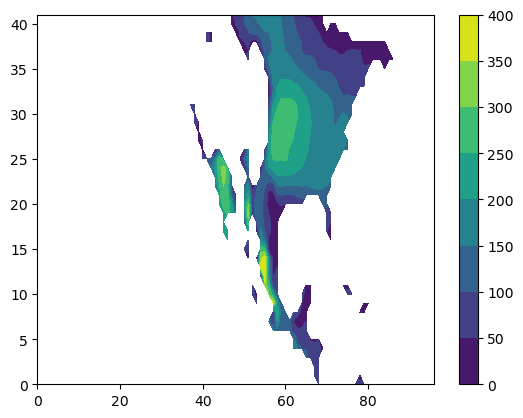

In [27]:
ctpMean = DS_main.CTP.median(dim='time').values
ctpMean[np.where(ctpMean<0)] = np.nan

plt.contourf(landMask*ctpMean)
plt.colorbar()

In [ ]:
plt.contourf(landMask*DS_main.HIlow.mean(dim='time').values)
plt.colorbar()

In [28]:
category = np.full([len(DS_main.lat.values), len(DS_main.lon.values)], 'NotClassifiedYet')


for iLat in range(len(DS_main.lat.values)):
    for iLon in range(len(DS_main.lon.values)): 
        thisPoint = DS_main.isel(lat=iLat,lon=iLon)
        nDays     = len(thisPoint.time.values)

        # Confirm we have CTP values (over land)
        if np.all(np.isfinite(thisPoint.CTP.values)==True):
            iAtmControl = np.where((thisPoint.CTP.values<=0) | (thisPoint.HIlow.values<=5) | (thisPoint.HIlow.values>=15) )[0]
            iWetRegime  = np.where((thisPoint.CTP.values>0) & (thisPoint.HIlow.values>5) &  (thisPoint.HIlow.values<10))[0]
            iDryRegime  = np.where((thisPoint.CTP.values>0) & (thisPoint.HIlow.values>=10) &  (thisPoint.HIlow.values<15))[0]

            nDays_atm = len(iAtmControl)
            nDays_other = nDays-nDays_atm

            if len(iAtmControl)>=np.floor(nDays*0.8):
                category[iLat,iLon]='AtmControl'
            elif len(iWetRegime)>=np.floor(nDays_other*0.5):
                category[iLat,iLon]='Positive_wet'
            elif len(iDryRegime)>=np.floor(nDays_other*0.5):
                category[iLat,iLon]='Negative_dry'
                


In [29]:
coded_array = np.full([len(DS_main.lat.values), len(DS_main.lon.values)], np.nan)
coded_array[np.where(category=='AtmControl')]   = 1
coded_array[np.where(category=='Positive_wet')] = 2
coded_array[np.where(category=='Negative_dry')] = 3


Text(0.5, 1.0, 'AMIP CESM2 CTP-HIlow classification')

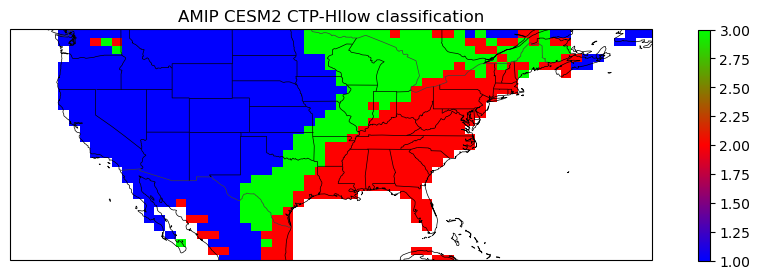

In [33]:
fig, axs = plt.subplots(1,1, figsize=(12, 3), 
                        subplot_kw={'projection':ccrs.PlateCarree()})

## Set up the map with boundaries, limited extent, etc.
axs.set_extent([230,305,22,49], crs=ccrs.PlateCarree())

axs.coastlines(linewidth=0.5,edgecolor='0.25')
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5) 

# axs[0].plot(np.ones(29)*249, np.arange(22,51), color='red', transform=ccrs.PlateCarree())
# axs.plot(np.ones(29)*254, np.arange(22,51), color='red', transform=ccrs.PlateCarree())

p1 = axs.pcolormesh(ctp.lon.values, ctp.lat.values, 
            coded_array,transform=ccrs.PlateCarree(), cmap='brg' )
c1 = fig.colorbar(p1)
axs.set_title('AMIP CESM2 CTP-HIlow classification')


In [193]:
a = DS_main.sel(lat=35, lon=250, method='nearest')

In [195]:
landMatters = DS_main.where(DS_main.CTP>0)
landMatters = landMatters.where((landMatters.HIlow>=5) & (landMatters.HIlow<=15))

wetSoilAdv = landMatters.where( (landMatters.HIlow<=10) )
drySoilAdv = landMatters.where( (landMatters.HIlow>=10) )


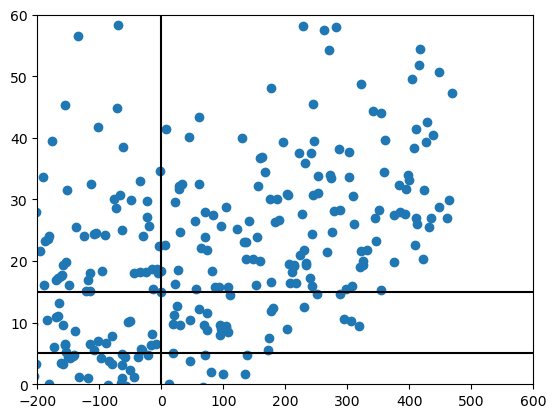

In [177]:
plt.scatter(a.CTP.values, a.HIlow.values)
plt.xlim(-200,600)
plt.ylim(0,60)

plt.axvline(0, color='k')
plt.axhline(15, color='k')
plt.axhline(5, color='k')

In [ ]:
i_atmControl = np.where()

In [160]:
HI_low

<xarray.DataArray (time: 2300, lat: 42, lon: 97)>
array([[[ 9.27935027e+00,  7.22973085e+00,  6.39311782e+00, ...,
          6.24484126e+00,  6.25566101e+00,  6.08338476e+00],
        [ 1.12997425e+01,  1.00371584e+01,  8.85662481e+00, ...,
          9.62375079e+00,  1.04702180e+01,  1.05920684e+01],
        [ 1.16906693e+01,  1.18584006e+01,  1.08199833e+01, ...,
          1.22948134e+01,  1.25521382e+01,  1.24102735e+01],
        ...,
        [ 7.14032066e-01,  9.82176899e-01,  1.46445784e+00, ...,
          1.25391699e+00,  5.65485280e-01,  1.67140136e-02],
        [ 1.90639835e-02,  1.33083033e-01,  1.00574710e+00, ...,
          1.94845401e+00,  1.27159414e+00,  1.00211639e-01],
        [ 3.78426115e-02,  1.72482110e-01,  3.52067568e-01, ...,
          2.10628979e+00,  2.40491620e+00,  1.20720213e+00]],

       [[ 2.72061119e+00,  2.73987221e+00,  3.18965488e+00, ...,
          1.03594036e+01,  1.20452319e+01,  1.31800188e+01],
        [ 4.12564446e+00,  4.90299765e+00,  7.48277780e+00, ...,
          1.45958964e+01,  1.48481599e+01,  1.52695427e+01],
        [ 5.44667300e+00,  6.90533934e+00,  8.26265437e+00, ...,
          1.59261971e+01,  1.48663642e+01,  1.46080944e+01],
...
        [ 6.90425332e+00,  7.97965475e+00,  7.74977366e+00, ...,
          1.49859648e+01,  2.00229565e+01,  2.29511502e+01],
        [ 8.25254124e+00,  6.58788940e+00,  5.55157685e+00, ...,
          1.81770908e+01,  1.90774457e+01,  1.79191221e+01],
        [ 6.23937840e+00,  5.37322812e+00,  4.81712146e+00, ...,
          1.37723144e+01,  1.09145988e+01,  9.75049692e+00]],

       [[ 4.56604927e+00,  3.26451432e+00,  2.35016931e+00, ...,
          4.68445081e+00,  4.70512576e+00,  5.36917534e+00],
        [ 3.96979264e+00,  2.74581391e+00,  2.41798768e+00, ...,
          4.26823001e+00,  4.32178850e+00,  4.40495755e+00],
        [ 3.26133983e+00,  2.54360565e+00,  2.92997690e+00, ...,
          4.30857667e+00,  4.15877844e+00,  3.57284925e+00],
        ...,
        [ 5.42191620e+00,  5.16260783e+00,  4.68039233e+00, ...,
          1.17739074e+00,  6.99161933e-01,  1.19083565e-01],
        [ 2.32522929e+00,  1.66627985e+00,  1.30625216e+00, ...,
          7.96469263e+00,  8.20945963e+00,  8.98745605e+00],
        [-5.71065563e-02,  5.33338438e-02,  5.91251478e-02, ...,
          8.55473643e+00,  1.28504603e+01,  1.37106539e+01]]])
Coordinates:
  * time     (time) object 0002-06-01 10:30:00 ... 0026-08-31 10:30:00
  * lat      (lat) float64 10.84 11.78 12.72 13.66 ... 46.65 47.59 48.53 49.48
  * lon      (lon) float64 190.0 191.2 192.5 193.8 ... 306.2 307.5 308.8 310.0

In [155]:
ctp

<xarray.DataArray (time: 2300, lat: 42, lon: 97)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 0002-06-01 10:30:00 ... 0026-08-31 10:30:00
  * lat      (lat) float64 10.84 11.78 12.72 13.66 ... 46.65 47.59 48.53 49.48
  * lon      (lon) float64 190.0 191.2 192.5 193.8 ... 306.2 307.5 308.8 310.0